# Create Features

This code cleans the data a bit more to construct key variables that can be inserted into a model . It undertakes some simple visualization of the log error before moving into some of the geospatial analysis of the Zillow Housing dataset using the geolocation points provided in the properties dataset.  This code aims to:

1. Document where there are heavy sales of properties over the course of 2016 
2. Describe how geographic locations relate to log error estimates 
3. Construct relevant geographical indicators that may better capture important spatial variations that relate to the log error.  

It is believed that a geographical perspective could help to improve predictions as location typically is one of the most important factors in deciding housing prices.  It is hypothesized that the larger logerrors arise from inability to capture some of these locational features so this code focuses on creating new features that could captures some of these aspects.

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

#Use the data processed in the first set of code that is significantly compressed compared to the raw data
ptrain = pd.read_csv("processed_train_2016.csv")
ptrain.head()

,Unnamed: 0,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,...,roomcnt,unitcnt,yardbuildingsqft17,yearbuilt,numberofstories,taxvaluedollarcnt,assessmentyear,taxamount,logerror,transactiondate
0,0,17073783,-1,2.5,3.0,NaN,1264.0,-1,2.0,2,...,5.0,-1,128,1986.0,2,191811.0,2015.0,2015.06,0.0953,2016-01-27
1,1,17088994,-1,1.0,2.0,NaN,777.0,-1,1.0,1,...,4.0,-1,198,1990.0,1,239679.0,2015.0,2581.30,0.0198,2016-03-30
2,2,17100444,-1,2.0,3.0,NaN,1101.0,-1,2.0,2,...,5.0,-1,-1,1956.0,1,47853.0,2015.0,591.64,0.0060,2016-05-27
3,3,17102429,-1,1.5,2.0,NaN,1554.0,1,1.0,2,...,5.0,-1,-1,1965.0,1,62914.0,2015.0,682.78,-0.0566,2016-06-07
4,4,17109604,-1,2.5,4.0,NaN,2415.0,1,2.0,2,...,8.0,-1,-1,1984.0,2,554000.0,2015.0,5886.92,0.0573,2016-08-08


In [260]:
#Clean the sold houses (train) dataset this data is more complete then the dataset of all houses

def clean_train(data):
    #need to clean this variable
    #print(data["heatingorsystemtypeid"].value_counts())
  
    true_floats = ["latitude","longitude","bathroomcnt"]

    #create new variable known as missing and convert all missing values (-1) to 0
    numeric_cols = data.select_dtypes(include=["int","float"])
    
    for col in numeric_cols:
        if col not in ["parcelid","logerror"]:
            data[col].fillna(-1,inplace=True)
            if col not in true_floats:
                data[col]=data[col].astype('int')
            #subgroup.ix[subgroup[col]==-1,col]= np.NaN
            data["miss_"+col] = [1 if math.floor(row) == -1 else 0 for row in data[col]]
            #print(data["miss_"+col].value_counts())
    
    #print(data.describe())
    
    #based on this let's just say it is year or no (doesn't really seem to be documenting if no -- so just fill with 0)
    data["regionidzip"].fillna(0,inplace=True)
    data["heatingcentral"] = (data["heatingorsystemtypeid"]==2) | (data["heatingorsystemtypeid"]==6) | (data["heatingorsystemtypeid"]>=20)
    data["heatingfloor"] = (data["heatingorsystemtypeid"]==7)

    #print(ptrain["heatingorsystemtypeid"].value_counts())
    #print(ptrain["heatingcentral"].value_counts())
    #print(ptrain["heatingfloor"].value_counts())

    #Now let's try extrapolating values for important variables let's denote e_[variable]
    #The buildingqualitytypeid we will base this value on the year built variable let's put into decade variables
    #we work on the assumption that a lot of building trends are driven by the year that a house was built

    data["grp_year"] = np.floor(data["yearbuilt"]/10)*10
    means = data.groupby(by="grp_year").mean()
    #print(type(means))
    #print(fulldata.groupby(by="grp_year").mean())

    cols = ["buildingqualitytypeid","numberofstories","fireplacecnt","garagecarcnt"]
    fullcols = cols
    fullcols.extend(["grp_year","regionidzip"])
    #print(fullcols)
    newcols = []

    subgroup = data[fullcols]
    fillvalues = subgroup[cols].fillna(subgroup.groupby("grp_year").transform("median"))
    for col in cols:
        newcols.append("e_"+col)
    
    fillvalues.columns = newcols
    #print(fillvalues.head())

    data = pd.concat([data, fillvalues], axis=1, join_axes=[data.index])
    #print(data.head())
    
    keep_cols = []
    missingvals = data.isnull().sum()
    for key, val in missingvals.items():
        if missingvals[key] <= len(data)*.1:
            keep_cols.append(key)
    #print(keep_cols)
    
    data = data[keep_cols]
    
    #For example we could take the z-estimate from all other houses or similar type houses in the dataset 
    #(i.e similar type houses going over the market price/value)

    #Now let's try extrapolating values for important variables let's denote e_[variable]
    #The buildingqualitytypeid we will base this value on the year built variable let's put into decade variables
    #we work on the assumption that a lot of building trends are driven by the year that a house was built

    #print(type(means))
    #print(fulldata.groupby(by="grp_year").mean())

    #below analysis shows that there is some areas where the z-estimate is particularly off
    subgroup = data[["regionidzip","logerror"]]
    #print(subgroup.groupby("regionidzip").mean())

    data['sum_zip_logerror'] = data['logerror'].groupby(data['regionidzip']).transform('sum')
    data['cnt_zip_logerror'] = data['logerror'].groupby(data['regionidzip']).transform('count')

    #average zip log error of other houses in area (not own house)
    data["other_avg_zip_logerror"] = (data['sum_zip_logerror']-data["logerror"])/(data['cnt_zip_logerror']-1)

    #print(data['other_avg_zip_logerror'].head(),data['sum_zip_logerror'].head(),data['cnt_zip_logerror'].head())
    data["mean_zip_logerror"] = data["logerror"].groupby(data['regionidzip']).transform('mean')
    
    #average deviations of other houses in area (by month)...this might give some variation in how z-score deviaties
    from datetime import datetime
    #print(data.dtypes)
    data["tdate_month"] = [datetime.strptime(d, "%Y-%m-%d").month for d in data["transactiondate"]]
    data["tdate_year"] = [datetime.strptime(d, "%Y-%m-%d").year for d in data["transactiondate"]]
    data["tdate_day"] = [datetime.strptime(d, "%Y-%m-%d").day for d in data["transactiondate"]]
    #print(data["tdate_month"].head())
    
    data["sum_mtcity_logerror"] = data.groupby(["tdate_month","regionidcity"])["logerror"].transform('sum')
    data["cnt_mtcity_logerror"] = data.groupby(["tdate_month","regionidcity"])["logerror"].transform('count')
    data["other_avg_mtcity_logerror"] = (data['sum_mtcity_logerror'] - data['logerror'])/(data['cnt_mtcity_logerror']-1)
    data["mean_mtcity_logerror"] = data.groupby(["tdate_month","regionidcity"])["logerror"].transform('mean')
    
    # both pool count and garage car count are non-zero only suggesting we can set to zero if missing
    data.loc[data['poolcnt'].isnull()==True] = 0
    data.loc[data['garagecarcnt'].isnull()==True]=0
    
    return(data)

In [261]:
ptrain_final = clean_train(ptrain)
ptrain_final["regionidcounty"].value_counts()
#new_data["regionidcity"].value_counts()

temp = ptrain_final[["logerror","tdate_month","regionidcounty"]]
average_month = temp.groupby(["tdate_month","regionidcounty"]).mean()
std_month = temp.groupby(["tdate_month","regionidcounty"]).std()
average_month.reset_index(level=0, inplace=True)
average_month.reset_index(level=0, inplace=True)
std_month.reset_index(level=0, inplace=True)
std_month.reset_index(level=0, inplace=True)
#print(average_month)


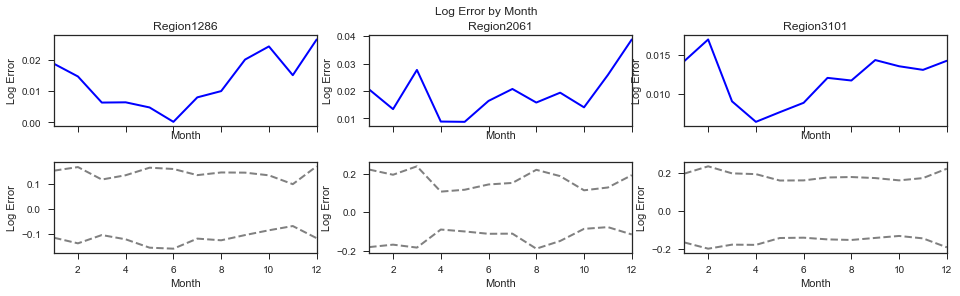

In [262]:
#Graphs appear to show that the log error is substantially off depending on month
#Will need to create statistics that capture month to month variation
#fig = plt.figure(figsize=(3, 9))
fig, ax = plt.subplots(nrows = 2, ncols= 3, figsize=(16,4), sharex=True)
plt.suptitle("Log Error by Month")
for i, reg in enumerate([1286,2061,3101]):
    avg_month = average_month[round(average_month["regionidcounty"],0)==reg]
    stdev_month_p1 = average_month[round(average_month["regionidcounty"],0)==reg] + std_month[round(std_month["regionidcounty"],0)==reg]
    stdev_month_m1 = average_month[round(average_month["regionidcounty"],0)==reg] - std_month[round(std_month["regionidcounty"],0)==reg]
    
    ax[0,i].set_xlim(1, 12)
    ax[0,i].set_xlabel("Month")
    ax[0,i].set_ylabel("Log Error")
    ax[0,i].set_title("Region" + str(reg))
    ax[0,i].plot(avg_month['tdate_month'], avg_month["logerror"], c='blue', label='Month', linewidth=2)

    ax[1,i].set_xlim(1, 12)
    ax[1,i].set_xlabel("Month")
    ax[1,i].set_ylabel("Log Error")
    ax[1,i].plot(avg_month['tdate_month'], stdev_month_p1["logerror"], c='grey', label='Month', linestyle = "dashed", linewidth=2)
    ax[1,i].plot(avg_month['tdate_month'], stdev_month_m1["logerror"], c='grey', label='Month', linestyle = "dashed", linewidth=2)
    fig.subplots_adjust(hspace=0.4)

### Log Error Over Time

The graphs shows that the log error appears to be significantly higher both in January and December.  It also is more likely to be lower during the month of June which could potentially be correlated with market turnover as June is possibly a prime month for many people to move.  Higher log error estimates also tends to be associated disproportionately with larger levels of standard deviations.

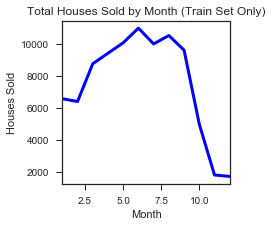

In [263]:
temp = ptrain_final[["logerror","tdate_month"]]
count_month = temp.groupby(["tdate_month"]).count()
count_month.reset_index(level=0, inplace=True)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1, 12)
ax.set_xlabel("Month")
ax.set_ylabel("Houses Sold")
ax.set_title("Total Houses Sold by Month (Train Set Only)")
ax.plot(count_month['tdate_month'], count_month["logerror"], c='blue', label='Month', linewidth=3)

One potential challenge is that in the training dataset we have a big drop off in houses sold because Zillow only provided part of the set from October onward.  That means valid estimates will only work if we are able to construct time series data from all months or basically eliminate the the usage of any supply-demand tightness variables (unless they are based on mean variables).  For example can just use average(log(error)) by month.

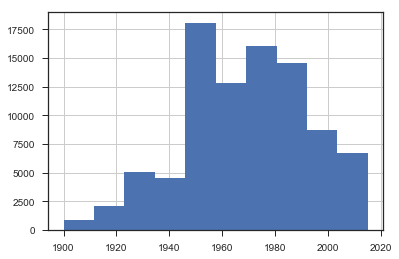

In [264]:
# Trends in houses built
temp = ptrain_final[ptrain_final["yearbuilt"] >= 1900]
temp["yearbuilt"].hist()

In [265]:
#Examine correlations (that are above 0.03)
print(ptrain_final.shape)
corr = ptrain_final.corr(method="pearson")
print(corr.loc[abs(corr["logerror"]) > 0.03,"logerror"])


(90811, 69)
bathroomcnt                          0.038998
bedroomcnt                           0.037372
calculatedfinishedsquarefeet         0.045254
fullbathcnt                          0.037481
latitude                             0.051154
longitude                           -0.051020
propertylandusetypeid                0.049572
regionidzip                          0.041160
yearbuilt                            0.036009
assessmentyear                       0.050926
logerror                             1.000000
miss_bathroomcnt                    -0.050926
miss_bedroomcnt                     -0.050926
miss_calculatedfinishedsquarefeet   -0.039277
miss_latitude                       -0.050926
miss_longitude                      -0.050926
miss_propertylandusetypeid          -0.050926
miss_regionidcounty                 -0.050926
miss_regionidzip                    -0.048677
miss_roomcnt                        -0.050926
miss_yearbuilt                      -0.034492
miss_taxvaluedollarcnt

### Correlations

The correlation between log error and various other constructed measures seems to indicate that it is more correlated with geographical features, missing data issues and to a lesser extent house size, and the year the house was built. 

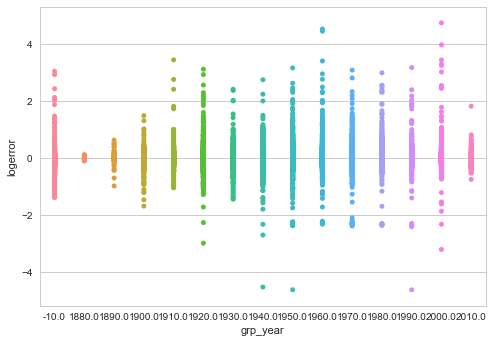

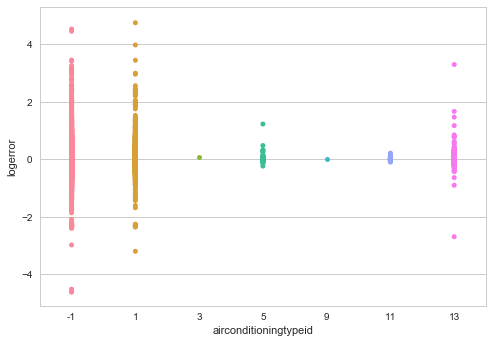

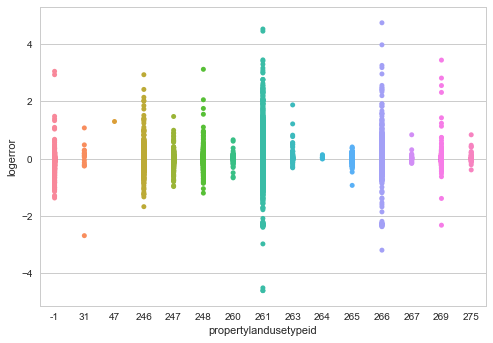

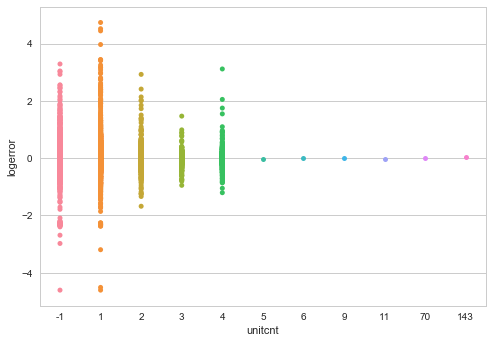

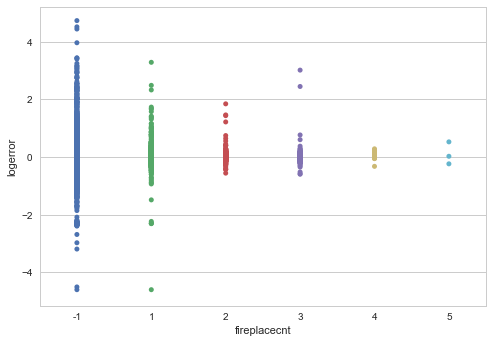

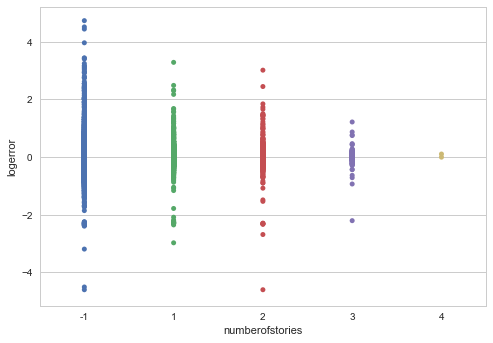

In [266]:
# Want to analyze logerror by missing variables, variables that have a value and using mean
# This hypothetically will allow us to assess whether we should replace missing variables with mean, median, or keep as missing

import seaborn as sns

miss_cols = ["grp_year","airconditioningtypeid","propertylandusetypeid","unitcnt","fireplacecnt","numberofstories"]

for col in miss_cols:
    #print(pd.crosstab(index=ptrain_final[col], columns='count'))
    # missing data indicates there are no zero values so it is either missing or filled in
    #temp = ptrain_final["logerror"]
    #how to graph the log error by missing and non-missing values
    sns.set(style="whitegrid", color_codes=True)
    sns.stripplot(x=col, y="logerror", data=ptrain_final);
    plt.show()
    

### Log error distribution by grouped categorical variables

For many of the variables where there is missing data the spread of the log-error is often greater than the spread where the data is not missing.  This tends to indicate that keeping it as a separate variable compared to those that are not.  For the pool cnt it looks potetnially to assume that those where no pool is indicated can be set to 0 and similarly with the fireplace count.

## Examine Geographical Features

In [267]:
def format_data(data,trainvars=True):
    
    #note that latitude and longitude are valued at 10e^6 (so we need to divide by a million to get back into values that are interpretable)
    data['latitude'] = data['latitude']/1000000
    data['longitude'] = data['longitude']/1000000
    
    #we do not need the level of accuracy to 6 decimal places so we will round down to 5 to potentially make things easier
    data["latitude"] = [round(row,5) for row in data["latitude"]]
    data["longitude"] = [round(row,5) for row in data["longitude"]]
    
    #create latitude and longitude data with 0 accuracy for rapid storage option
    data["latr0"] = [round(row,1) for row in data["latitude"]]
    data["lonr0"] = [round(row,1) for row in data["longitude"]]
    
    # want to recode property land use values
    data['miss_proplu'] = data['propertylandusetypeid'].isnull()==1
    data['propertylandusetypeid'].fillna(0,inplace=True)
    # 0 = mixed usage, 1 = duplex, 2 = triplex/quadruplex, 3 = residential other, 4 = single family
    # 5 = mobile home, condos = 6, planned unit development = 7, 
    proplu_def = { 31 : 0, 46 : 0, 47 : 0, 246 : 1, 247 : 2, 248 : 2, 260 : 3, 261 : 4, 262 : 3, 
                  263 : 5, 264 : 2, 265 : 2, 266 : 6, 267 : 2, 268 : 2, 269 : 7, 270 : 3, 275 : 3}
    data['grp_proplu'] = data['propertylandusetypeid'].astype('int').replace(proplu_def)
    dummies = pd.get_dummies(data['grp_proplu'],prefix='proplu')
    data = pd.concat([data,dummies], axis=1)    
    
    if trainvars == True:
        
        data["lat_2"] = [round(row,2) for row in data["latitude"]]
        data["lon_2"] = [round(row,2) for row in data["longitude"]]
        
        data["lat_3"] = [round(row,3) for row in data["latitude"]]
        data["lon_3"] = [round(row,3) for row in data["longitude"]]
        #data["latitude"].fillna(0,inplace=True)
        #data["longitude"].fillna(0,inplace=True)
        #print(data.head())
    
        subset1 = data[['lon_3','latitude']]
        subset2 = data[['lat_3','longitude']]
        grouped = subset1.groupby(['lon_3'])
        min_latitude = grouped.agg(np.min)
        min_latitude.reset_index(inplace=True)
        min_latitude.columns = ['lon_3','min_latitude']
        #print(min_latitude)
        grouped = subset2.groupby(['lat_3'])
        min_longitude = grouped.agg(np.min)
        min_longitude.reset_index(inplace=True)
        min_longitude.columns = ['lat_3','min_longitude']
        #print(min_longitude)
    
        data = data.merge(min_latitude,how="left",left_on='lon_3', right_on='lon_3')
        data = data.merge(min_longitude,how="left",left_on='lat_3', right_on='lat_3')
        data['possible_beachview'] = [1 if row['min_latitude'] == row['latitude'] else 0 for key, row in data.iterrows()]    
    
    data = data.loc[data['regionidzip'].isnull()==0,:]
    
    return data

In [268]:
ptrain_final = format_data(ptrain_final,trainvars=True)

In [269]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def create_categoricalmap(data,keyvar,titlename,colortype):

    # setup Lambert Conformal basemap.
    m = Basemap(lon_0=-118.501215,lat_0=3.804698,projection='merc',llcrnrlat=33.32,urcrnrlat=34.9,
            llcrnrlon=-119.447860, urcrnrlon=-117.5,resolution = 'h', epsg=4269, area_thresh = 0.1)
    plt.figure(figsize=(10,10))
    # Read county boundaries
    shp_info = m.readshapefile('cb_2016_us_county_500k',
                              'counties',
                               drawbounds=True,zorder=3)
    #this will be the color of the ocean
    m.drawmapboundary(fill_color='#85A6D9')
    m.fillcontinents(color='white',lake_color='#85A6D9')
    m.drawcoastlines(color='#6D5F47', linewidth=.4)
    m.drawrivers()
    #try to plot how land use is described for each of the houses in the dataset
    longitudes = data["longitude"].tolist()
    latitudes = data["latitude"].tolist()
    m.scatter(longitudes,latitudes,latlon=True,c=data[keyvar],cmap=colortype,zorder=2)
    plt.title(titlename)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar()
    #m.scatter(ptrain['longitude'],ptrain['latitude'],latlon=True,color='purple',zorder=2)
    plt.show()

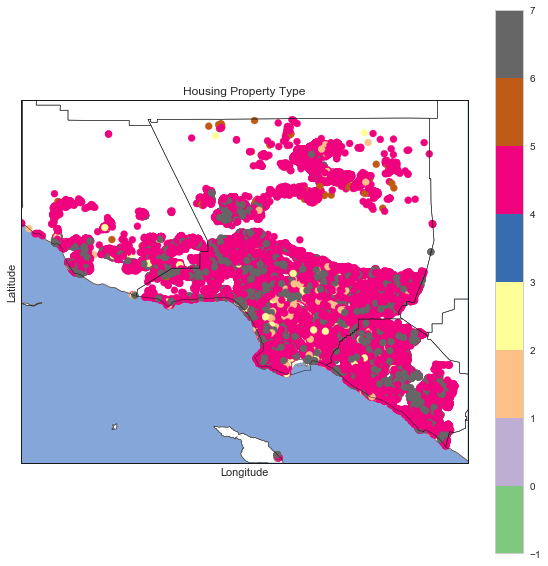

In [270]:
create_categoricalmap(ptrain_final,'grp_proplu','Housing Property Type','Accent')

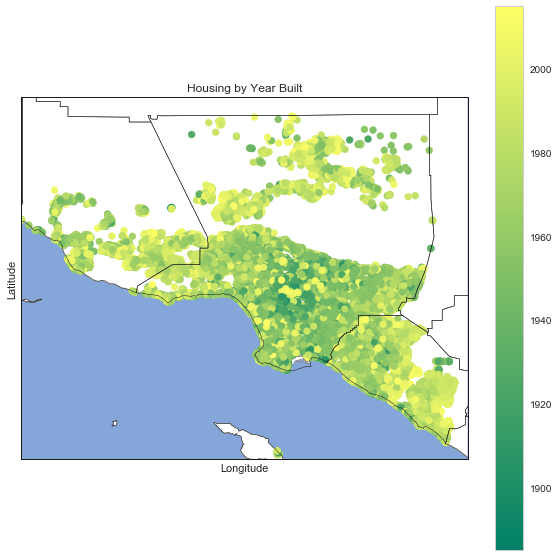

In [271]:
create_categoricalmap(ptrain_final.loc[ptrain_final['yearbuilt'] > 1800],'yearbuilt','Housing by Year Built','summer')

## Location of houses

The location of houses are along the coast line with many houses sitting right on the beach/shoreline.  This type of view should be taken into account when we estimate housing prices.  Some thoughts on how we can estimate this.  First houses with the lowest latitude for a given longitude are those located on the beach (or vice versa).  Note that there is an area that is not close to the beach (yet still might have some sort of views.  However, and we may want to exclude this.  Another set of houses are more rural and could be bordering green space area that may also contribute to differential values of the houses.  What we might want to do is estimate the closest distance to beach/shoreline for various houses or houses that are withing 1km from beach/shoreline.  The weather in these areas is more desirable and enjoyable.  Pink areas are condominium usage designated areas.  Blue areas are single family residential housing.

The map indicating the year built of houses appears to show that newer regions do tend to be on the outskirts with some newer houses being interspersed within the highly populated areas.

1    43004
2    18411
0     2764
3     2600
Name: dlogerror, dtype: int64


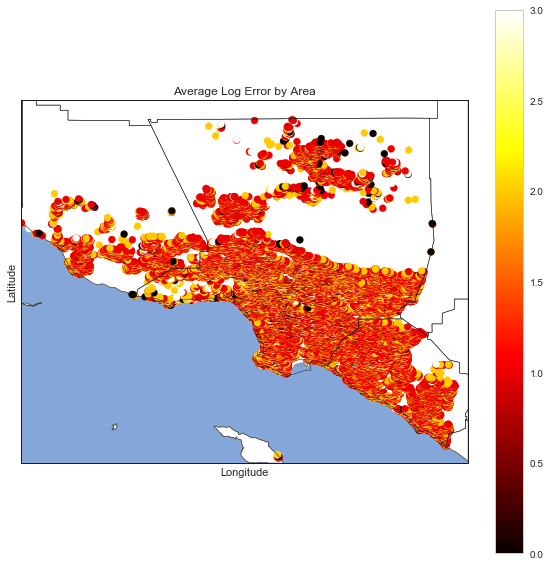

In [272]:
#try to plot different log-error values in dataset
grouped = ptrain_final.groupby(['lat_3','lon_3'])
average = grouped.agg(np.mean)
average.reset_index(inplace=True)
average.reset_index(inplace=True)

bins = [-4.605000,0.0281666-0.174,0.0281666,0.0281666+0.174,4.737000]
label_bins = [0, 1, 2, 3]
#label_bins = ["N1SD","BM","AM","P1SD"]
average["dlogerror"] = pd.cut(average["logerror"],bins,labels=label_bins)
print(average["dlogerror"].value_counts())
#print(average)

create_categoricalmap(average,'dlogerror','Average Log Error by Area','hot')

This graph indicates that the log error does not vary that much geographically.  While there are both overpredictions and undepredictions it appears that there are both over and under predictions within the same neighborhoods.  However, there appears to be slightly higher chances of underpredictions of the model near the coastal areas and in areas where there is better views (brown and red areas).  There are also appears to be more clustering in the underpredictions indicating potentially very localized neighborhood effects that cause housing prices to go for higher than expected.

## Create Distance Variables

In [273]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame

# Estimate the distance from the coast
def distance_from_coast(data,resolution='h',degree_in_km=111.12):
    coastdata = gpd.read_file("california_coastline.shp")
    coastdata_coords = np.vstack(coastdata.geometry)
    #only keep coordinates that are within relevant area (to speed things up)
    coastdata_new = coastdata_coords[coastdata_coords[:,0] >= -120]
    coastdata_new = coastdata_new[coastdata_new[:,0] <= -117]
    coastdata_new = coastdata_new[coastdata_new[:,1] >= 33.3]
    coastdata_new = coastdata_new[coastdata_new[:,1] <= 35]
    lons,lats = m(coastdata_new[:,0],coastdata_new[:,1],inverse=True)
    #convert into distance function     
    distance = [np.min(np.sqrt((lons-row['longitude'])**2+(lats-row['latitude'])**2))*degree_in_km for index, row in data.iterrows()]
    return distance

def extract_poly_coords(geom):
    if geom.type == 'Polygon':
        exterior_coords = geom.exterior.coords[:]
        interior_coords = []
        for interior in geom.interiors:
            interior_coords += interior.coords[:]
    elif geom.type == 'MultiPolygon':
        exterior_coords = []
        interior_coords = []
        for part in geom:
            epc = extract_poly_coords(part)  # Recursive call
            exterior_coords += epc['exterior_coords']
            interior_coords += epc['interior_coords']
    else:
        raise ValueError('Unhandled geometry type: ' + repr(geom.type))
    return {'exterior_coords': exterior_coords,
            'interior_coords': interior_coords}

def distance_from_border(data,resolution='h',degree_in_km=111.12):
    border = gpd.read_file('cb_2016_us_county_500k.shp')
    border = border.loc[border['STATEFP']=='06',:]
    border = border.loc[border['COUNTYFP'].isin(['037','059','111']),:]
    border.reset_index(inplace=True)
    #print(border)
    #print(border.geometry.type)
    for i, b in border.iterrows():
        coords = extract_poly_coords(b.geometry)
        #print(i)
        if i == 0:
            border_coords = np.vstack(coords['exterior_coords'])
        else:
            border_coords = np.concatenate([border_coords,np.vstack(coords['exterior_coords'])],axis=0)
    lons,lats = m(border_coords[:,0],border_coords[:,1],inverse=True)
    distance = [np.min(np.sqrt((lons-row['longitude'])**2+(lats-row['latitude'])**2))*degree_in_km for index, row in data.iterrows()]
    return distance

In [274]:
ptrain_final['distance_to_beach'] = distance_from_coast(ptrain_final)
ptrain_final['distance_to_border'] = distance_from_border(ptrain_final)

In [275]:
# Examine the construction of the distance variables

def generate_map(data,maptitle,colortype):
    # setup Lambert Conformal basemap.
    m = Basemap(lon_0=-118.501215,lat_0=3.804698,projection='merc',llcrnrlat=33.32,urcrnrlat=34.9,
            llcrnrlon=-119.447860, urcrnrlon=-117.5,resolution = 'h', epsg=4269, area_thresh = 0.1)
    
    # Read county boundaries
    shp_info = m.readshapefile('cb_2016_us_county_500k',
                              'counties',
                               drawbounds=True,zorder=3)
    
    #this will be the color of the ocean
    m.drawmapboundary(fill_color='#85A6D9')
    m.fillcontinents(color='white',lake_color='#85A6D9')
    m.drawcoastlines(color='#6D5F47', linewidth=.4)
    m.drawrivers()
    #try to plot how land use is described for each of the houses in the dataset
    longitudes = data["longitude"].tolist()
    latitudes = data["latitude"].tolist()

    m.scatter(longitudes,latitudes,latlon=True,color=colortype,zorder=2)
    plt.title(maptitle)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    plt.show()

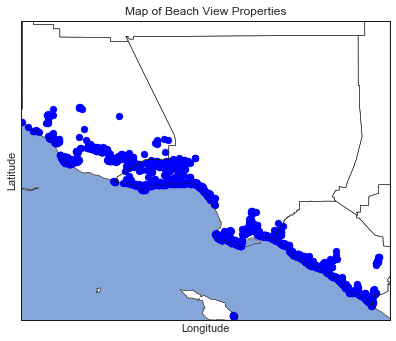

In [276]:
generate_map(ptrain_final.loc[ptrain_final['possible_beachview']==1],"Map of Beach View Properties",'blue')

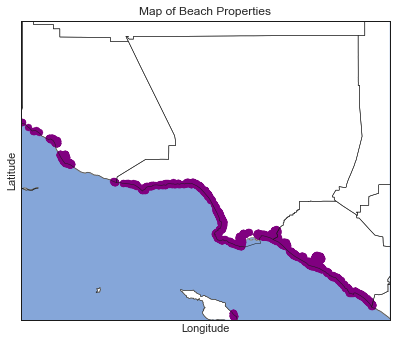

In [277]:
#check to make sure that the distances were computed correctly
generate_map(ptrain_final.loc[(ptrain_final['distance_to_beach']<1),:],"Map of Beach Properties","purple")

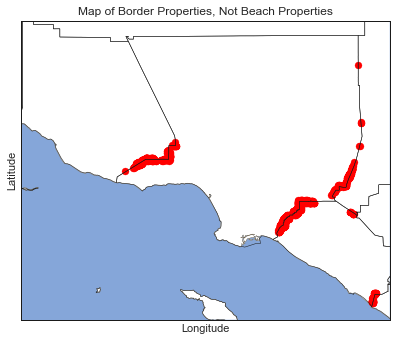

In [278]:
generate_map(ptrain_final.loc[(ptrain_final['distance_to_border']<1) & (ptrain_final['distance_to_beach']>1.5),:],"Map of Border Properties, Not Beach Properties",'red')

Possible future improvements could create measures of neighborhood quality, etc. based on characteristics of houses in an area (or buffer zone).
Buffer zone approach however is potentially a slow process and requires reducing the search grid to compute these values more efficiently.

In [279]:
#Examine correlations (that are above 0.04)
# few more variables
ptrain_final["beach_property"] = ptrain_final['distance_to_beach']<1
ptrain_final["border_property"] = (ptrain_final['distance_to_border']<1) & (ptrain_final['distance_to_beach']>1.5)

print(ptrain_final.shape)
corr = ptrain_final.corr(method="pearson")
print(corr.loc[np.abs(corr["logerror"]) > 0.03,"logerror"])

(90811, 93)
bathroomcnt                          0.038998
bedroomcnt                           0.037372
calculatedfinishedsquarefeet         0.045254
fullbathcnt                          0.037481
latitude                             0.051154
longitude                           -0.051020
propertylandusetypeid                0.049572
regionidzip                          0.041160
yearbuilt                            0.036009
assessmentyear                       0.050926
logerror                             1.000000
miss_bathroomcnt                    -0.050926
miss_bedroomcnt                     -0.050926
miss_calculatedfinishedsquarefeet   -0.039277
miss_latitude                       -0.050926
miss_longitude                      -0.050926
miss_propertylandusetypeid          -0.050926
miss_regionidcounty                 -0.050926
miss_regionidzip                    -0.048677
miss_roomcnt                        -0.050926
miss_yearbuilt                      -0.034492
miss_taxvaluedollarcnt

In [280]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



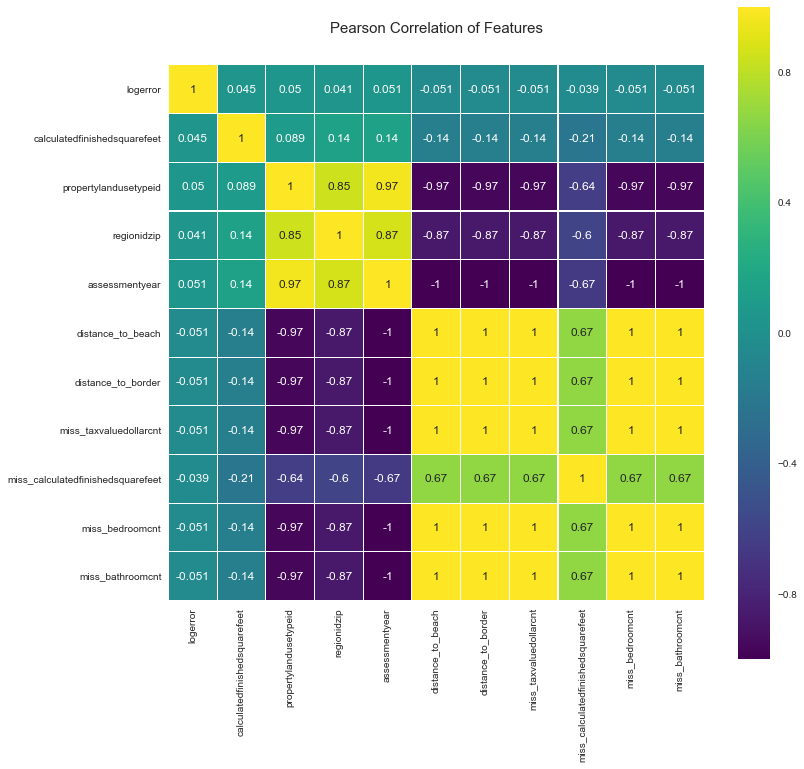

In [282]:
#generating a heat map for correlations of key variables
cols = ['logerror','calculatedfinishedsquarefeet','propertylandusetypeid','regionidzip','assessmentyear','distance_to_beach','distance_to_border','miss_taxvaluedollarcnt','miss_calculatedfinishedsquarefeet','miss_bedroomcnt','miss_bathroomcnt']
#print(keycols.index)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(ptrain_final[cols].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

The map shows that there is multicollinearity or very high correlations between a number of the variables.  These potentially should be combined together or only variables that are more unique should be selected for inclusion in the final model.  In particular, a lot of the distance variables and miss variable problems commonly are held by the same observation so the better approach may be to simply have a variable indicating any missing data problem.

In [291]:
bins = [-1000,0,1000]
label_bins = ["negative","positive"]
ptrain_final["dlogerror"] = pd.cut(ptrain_final["logerror"],bins,labels=label_bins)
train = ptrain_final[["dlogerror"]+cols]
print(len(train))

train = train.dropna()
train.reset_index(inplace=True)
randind = np.random.permutation(len(train))
shuffled_new_data=train.loc[randind]
train_subset = shuffled_new_data.loc[0:np.floor(len(train)*0.30)]

90811


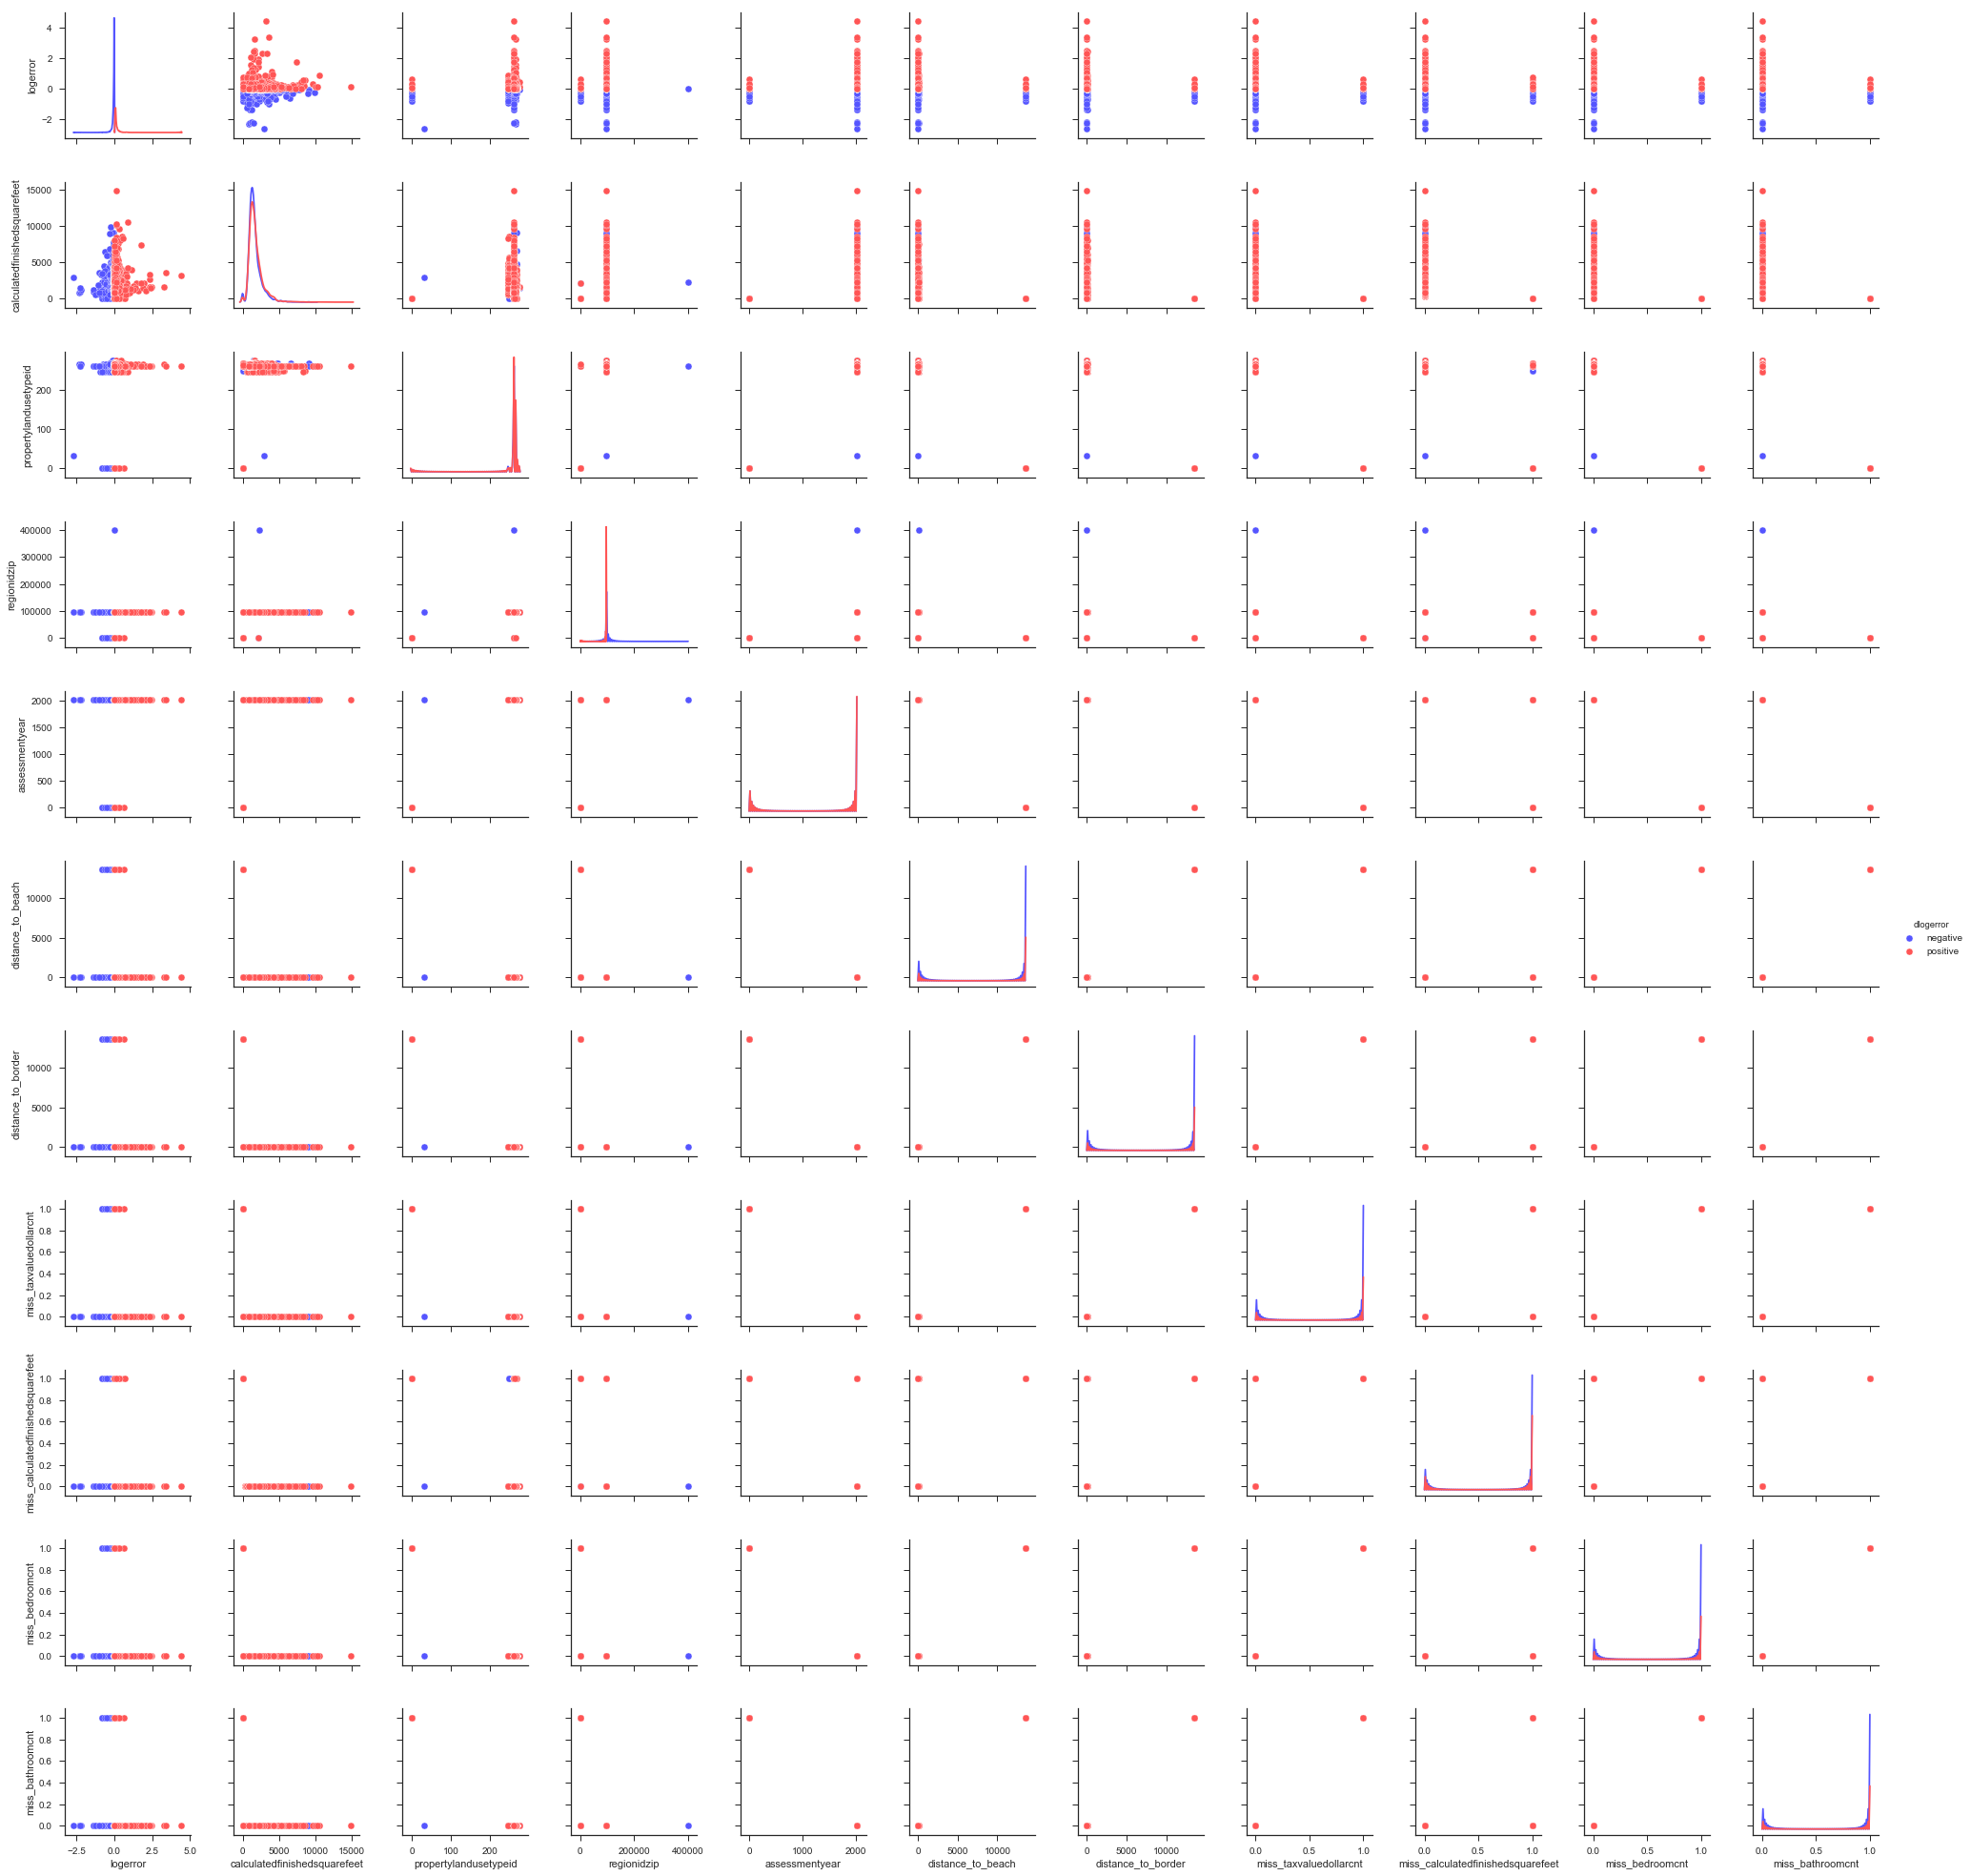

In [292]:
plt.figure(figsize=(12,12))
cols = ['logerror','calculatedfinishedsquarefeet','propertylandusetypeid','regionidzip','assessmentyear','distance_to_beach','distance_to_border','miss_taxvaluedollarcnt','miss_calculatedfinishedsquarefeet','miss_bedroomcnt','miss_bathroomcnt']
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(train_subset, vars=cols, hue="dlogerror", diag_kind="kde", palette='seismic')

The pair plots apear to indicate that those that are further from beach or further from the border of the counties tend to have a negative log error meaning the actual sales 
values on average tend to be lower than the estimated value of the property.  That is the current model of the z-estimate tends to overvalue some of these properties.  Likewise missing data is typically negatively associated with a more negative logerror that indicates the missing information leads to on average overvaluation of the house relative to the model estimates. 